<h1> GBDT </h1>

In [93]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import re
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from prettytable import PrettyTable
from scipy.sparse import coo_matrix,hstack

In [2]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [3]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dipali\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
sid = SentimentIntensityAnalyzer()
for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
score = sid.polarity_scores(for_sentiment)
for i in score:
    print('{0}: {1}, '.format(i, score[i]), end='')


neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


##  Loading Data

In [6]:
import pandas as pd
data = pd.read_csv('preprocessed_data.csv',nrows = 50000)
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [7]:
sent_score = []
for line in data['essay']:
    score = sid.polarity_scores(line)
    sent_score.append(score)

    

In [8]:
sentiment_data = pd.DataFrame(sent_score)
sentiment_data.head(2)


,neg,neu,pos,compound
0,0.013,0.783,0.205,0.9867
1,0.072,0.680,0.248,0.9897


In [9]:
data_new = pd.concat([data,sentiment_data],axis = 1)
data_new.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,neu,pos,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.680,0.248,0.9897


In [12]:
data_temp = data_new.copy()

In [13]:
X = data_new
X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,neu,pos,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.680,0.248,0.9897


In [14]:
y = data['project_is_approved']
y.head(2)

0    1
1    1
Name: project_is_approved, dtype: int64

<h2> Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(X_cv.shape),"  ",
print(y_train.shape)
print(y_test.shape)
print(y_cv.shape)

(22445, 13)
(16500, 13)
(11055, 13)
(22445,)
(16500,)
(11055,)


<h2> Encoding eassay, and project_title</h2>

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4))
vectorizer_tfidf.fit(X_train['essay'].values)

X_train_ess_tfidf = vectorizer_tfidf.transform(X_train['essay'].values)
X_cv_ess_tfidf = vectorizer_tfidf.transform(X_cv['essay'].values)
X_test_ess_tfidf = vectorizer_tfidf.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_ess_tfidf.shape, y_train.shape)
print(X_cv_ess_tfidf.shape, y_cv.shape)
print(X_test_ess_tfidf.shape, y_test.shape)

After vectorizations
(22445, 72149) (22445,)
(11055, 72149) (11055,)
(16500, 72149) (16500,)


In [20]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(data['essay'])
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [21]:

avg_w2v_vectors_train = [] 
for sentence in tqdm(X_train['essay'].values):
    vector = np.zeros(300)
    cnt_words = 0
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words +=1
    if cnt_words !=0:
        vector = vector / cnt_words
    avg_w2v_vectors_train.append(vector)
     

100%|██████████████████████████████████████████████████████████████████████████| 22445/22445 [00:06<00:00, 3509.20it/s]


In [22]:
avg_w2v_vectors_test = [] 
for sentence in tqdm(X_test['essay'].values):
    vector = np.zeros(300)
    cnt_words = 0
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words +=1
    if cnt_words !=0:
        vector = vector / cnt_words
    avg_w2v_vectors_test.append(vector)
     

100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:04<00:00, 3512.08it/s]


In [23]:
avg_w2v_vectors_cv = [] 
for sentence in tqdm(X_cv['essay'].values):
    vector = np.zeros(300)
    cnt_words = 0
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words +=1
    if cnt_words !=0:
        vector = vector / cnt_words
    avg_w2v_vectors_cv.append(vector)
     

100%|██████████████████████████████████████████████████████████████████████████| 11055/11055 [00:03<00:00, 3526.89it/s]


In [24]:
weigthed_tfid_train  = []
for sentence in tqdm(X_train['essay'].values):
    vector = np.zeros(300)
    tf_idf_wegthed = 0
    for word in sentence.split():
        if (word in glove_words and word in tfidf_words):
            vec = model[word]
            tf_idf =  dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += vec*tf_idf
            tf_idf_wegthed += tf_idf
    if (tf_idf_wegthed != 0):
        vector = vector / tf_idf_wegthed
    weigthed_tfid_train.append(vector)
    

100%|███████████████████████████████████████████████████████████████████████████| 22445/22445 [00:46<00:00, 484.00it/s]


In [25]:
weigthed_tfid_test  = []
for sentence in tqdm(X_test['essay'].values):
    vector = np.zeros(300)
    tf_idf_wegthed = 0
    for word in sentence.split():
        if (word in glove_words and word in tfidf_words):
            vec = model[word]
            tf_idf =  dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += vec*tf_idf
            tf_idf_wegthed += tf_idf
    if (tf_idf_wegthed != 0):
        vector = vector / tf_idf_wegthed
    weigthed_tfid_test.append(vector)

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [00:33<00:00, 498.14it/s]


In [26]:
weigthed_tfid_cv  = []
for sentence in tqdm(X_cv['essay'].values):
    vector = np.zeros(300)
    tf_idf_wegthed = 0
    for word in sentence.split():
        if (word in glove_words and word in tfidf_words):
            vec = model[word]
            tf_idf =  dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += vec*tf_idf
            tf_idf_wegthed += tf_idf
    if (tf_idf_wegthed != 0):
        vector = vector / tf_idf_wegthed
    weigthed_tfid_cv.append(vector)

100%|███████████████████████████████████████████████████████████████████████████| 11055/11055 [00:24<00:00, 446.22it/s]


In [27]:
weigthed_tfid_train = np.array(weigthed_tfid_train)
weigthed_tfid_train = weigthed_tfid_train.reshape((22445,300))
weigthed_tfid_test = np.array(weigthed_tfid_test)
weigthed_tfid_test = weigthed_tfid_test.reshape((16500,300))
weigthed_tfid_cv = np.array(weigthed_tfid_cv)
weigthed_tfid_cv = weigthed_tfid_cv.reshape((11055,300))

## Encoding numerical features

In [32]:
from sklearn.preprocessing import Normalizer
normalizer_noprojects = Normalizer()
X_train_noprojects_norm = normalizer_noprojects.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_noprojects_norm = normalizer_noprojects.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_noprojects_norm = normalizer_noprojects.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_noprojects_norm = X_train_noprojects_norm.reshape(-1,1)
X_cv_noprojects_norm = X_cv_noprojects_norm.reshape(-1,1)
X_test_noprojects_norm = X_test_noprojects_norm.reshape(-1,1)
print("after reshaping")
print(X_train_noprojects_norm.shape, y_train.shape)
print(X_cv_noprojects_norm.shape, y_cv.shape)
print(X_test_noprojects_norm.shape, y_test.shape)
print("=="*50)

after reshaping
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [33]:
from sklearn.preprocessing import Normalizer
normalizer_price = Normalizer()
X_train_price_norm = normalizer_price.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer_price.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer_price.transform(X_test['price'].values.reshape(1,-1))
X_train_price_norm = X_train_price_norm.reshape(-1,1)
X_cv_price_norm = X_cv_price_norm.reshape(-1,1)
X_test_price_norm = X_test_price_norm.reshape(-1,1)
print("after reshaping")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

after reshaping
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


from sklearn.preprocessing import Normalizer
normalizer_pos = Normalizer()
X_train_pos_norm = normalizer_pos.transform(X_train['pos'].values.reshape(1,-1))
X_cv_pos_norm = normalizer_pos.transform(X_cv['pos'].values.reshape(1,-1))
X_test_pos_norm = normalizer_pos.transform(X_test['pos'].values.reshape(1,-1))
X_train_pos_norm = X_train_pos_norm.reshape(-1,1)
X_cv_pos_norm = X_cv_pos_norm.reshape(-1,1)
X_test_pos_norm = X_test_pos_norm.reshape(-1,1)
print("after reshaping")
print(X_train_pos_norm.shape, y_train.shape)
print(X_cv_pos_norm.shape, y_cv.shape)
print(X_test_pos_norm.shape, y_test.shape)
print("=="*50)

In [35]:
from sklearn.preprocessing import Normalizer
normalizer_neg = Normalizer()
X_train_neg_norm = normalizer_neg.transform(X_train['neg'].values.reshape(1,-1))
X_cv_neg_norm = normalizer_neg.transform(X_cv['neg'].values.reshape(1,-1))
X_test_neg_norm = normalizer_neg.transform(X_test['neg'].values.reshape(1,-1))
X_train_neg_norm = X_train_neg_norm.reshape(-1,1)
X_cv_neg_norm = X_cv_neg_norm.reshape(-1,1)
X_test_neg_norm = X_test_neg_norm.reshape(-1,1)
print("after reshaping")
print(X_train_neg_norm.shape, y_train.shape)
print(X_cv_neg_norm.shape, y_cv.shape)
print(X_test_neg_norm.shape, y_test.shape)
print("=="*50)

after reshaping
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [36]:
from sklearn.preprocessing import Normalizer
normalizer_neu = Normalizer()
X_train_neu_norm = normalizer_neu.transform(X_train['neu'].values.reshape(1,-1))
X_cv_neu_norm = normalizer_neu.transform(X_cv['neu'].values.reshape(1,-1))
X_test_neu_norm = normalizer_neu.transform(X_test['neu'].values.reshape(1,-1))
X_train_neu_norm = X_train_neu_norm.reshape(-1,1)
X_cv_neu_norm = X_cv_neu_norm.reshape(-1,1)
X_test_neu_norm = X_test_neu_norm.reshape(-1,1)
print("after reshaping")
print(X_train_neu_norm.shape, y_train.shape)
print(X_cv_neu_norm.shape, y_cv.shape)
print(X_test_neu_norm.shape, y_test.shape)
print("=="*50)

after reshaping
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [37]:
from sklearn.preprocessing import Normalizer
normalizer_comp = Normalizer()
X_train_comp_norm = normalizer_comp.transform(X_train['compound'].values.reshape(1,-1))
X_cv_comp_norm = normalizer_comp.transform(X_cv['compound'].values.reshape(1,-1))
X_test_comp_norm = normalizer_comp.transform(X_test['compound'].values.reshape(1,-1))
X_train_comp_norm = X_train_comp_norm.reshape(-1,1)
X_cv_comp_norm = X_cv_comp_norm.reshape(-1,1)
X_test_comp_norm = X_test_comp_norm.reshape(-1,1)
print("after reshaping")
print(X_train_comp_norm.shape, y_train.shape)
print(X_cv_comp_norm.shape, y_cv.shape)
print(X_test_comp_norm.shape, y_test.shape)
print("=="*50)

after reshaping
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


## Encoding categorical features

In [39]:
def EncodingMethod_of_response(X_train,category):
    is_positive_val = dict(X_train[X_train['project_is_approved'] == 1].groupby(category).size())
    is_negative_val = dict(X_train[X_train['project_is_approved'] == 0].groupby(category).size())
    return is_positive_val,is_negative_val
def getting_Response(X_train,category,is_positive_val,is_negative_val):
    increment = dict(X_train.groupby(category).size())
    sorted(increment)
    list_of_category = list(increment.keys())
    positive_prob_val = []
    negative_prob_val = []
    for num in increment:

        if num in is_positive_val:
            pos_nume = is_positive_val[num]
            denomr = increment[num]
            positive_prob_val.append(pos_nume/denomr)
        if num not in is_positive_val:
            positive_prob_val.append(0)
        if num in is_negative_val:
            neg_nume = is_negative_val[num]
            denomr = increment[num]
            negative_prob_val.append(neg_nume/denomr)
        if num not in is_negative_val:
            negative_prob_val.append(0)
    df = pd.DataFrame({
        "categories":list_of_category,
        "positive":positive_prob_val,
        "negative":negative_prob_val
    })
    
    
    return df


In [40]:
def function_tobuildTest(X_train_n,X_test,column):
    increment1 = dict(X_test.groupby(column).size())
    list_positive_val = []
    list_negative_val = []
    num1 = list(X_train_n["categories"])
    pos_test_val = list(X_train_n["positive"])
    neg_test_val = list(X_train_n["negative"])
    test_cat = []
    for num in increment1:
        test_cat.append(num)
        if num in num1:
            list_positive_val.append(pos_test_val[num1.index(num)])
            list_negative_val.append(neg_test_val[num1.index(num)])
        else:
            list_positive_val.append(0.5)
            list_negative_val.append(0.5)
    df = pd.DataFrame({
    "categories":test_cat,
    "positive":list_positive_val,
    "negative":list_negative_val})
    return df
    
    

In [41]:
def function_to_buildDict(X):
    pos_dict_score = {}
    neg_dict_score = {}
    num2 = list(X["categories"])

    pos_val = list(X["positive"])
    neg_val = list(X["negative"])

    for i in range(len(num2)):
        pos_dict_score[num2[i]] = pos_val[i]
        neg_dict_score[num2[i]] = neg_val[i]
    return pos_dict_score,neg_dict_score

In [42]:
def creatingList(data_temp,pos_dict_score,neg_dict_score):
    pos_list_response = []
    neg_list_response = []
    for cat in data_temp:
        if cat in pos_dict_score or neg_dict_score:
            pos_list_response.append(pos_dict_score[cat])
            neg_list_response.append(neg_dict_score[cat])
    return pos_list_response,neg_list_response
    

##  Response encoding

In [46]:
is_positive_val,is_negative_val = EncodingMethod_of_response(X_train,"teacher_prefix")
X_train_teachprefix_ohe = getting_Response(X_train,"teacher_prefix",is_positive_val,is_negative_val)
X_test_teachprefix_ohe = function_tobuildTest(X_train_teachprefix_ohe,X_test,"teacher_prefix")
X_cv_teachprefix_ohe = function_tobuildTest(X_train_teachprefix_ohe,X_cv,"teacher_prefix")

pos_dict_score,neg_dict_score = function_to_buildDict(X_train_teachprefix_ohe)
train_t = list(X_train["teacher_prefix"])
train_pos_teacher,train_neg_teacher = creatingList(train_t,pos_dict_score,neg_dict_score)
pos_dict_score,neg_dict_score = function_to_buildDict(X_test_teachprefix_ohe)
test_t = list(X_test["teacher_prefix"])
test_pos_teacher,test_neg_teacher = creatingList(test_t,pos_dict_score,neg_dict_score)
pos_dict_score,neg_dict_score = function_to_buildDict(X_cv_teachprefix_ohe)
cv_t = list(X_cv["teacher_prefix"])
cv_pos_teacher,cv_neg_teacher = creatingList(cv_t,pos_dict_score,neg_dict_score)

print(len(train_pos_teacher),len(train_neg_teacher))
print(len(test_pos_teacher),len(test_neg_teacher))
print(len(cv_pos_teacher),len(cv_neg_teacher))

22445 22445
16500 16500
11055 11055


In [47]:
train_pos_teacher = np.array(train_pos_teacher)
train_pos_teacher = train_pos_teacher.reshape((22445,1))
train_neg_teacher = np.array(train_neg_teacher)
train_neg_teacher = train_neg_teacher .reshape((22445,1))

test_pos_teacher = np.array(test_pos_teacher)
test_pos_teacher = test_pos_teacher.reshape((16500,1))
test_neg_teacher = np.array(test_neg_teacher)
test_neg_teacher = test_neg_teacher.reshape((16500,1))

cv_pos_teacher = np.array(cv_pos_teacher)
cv_pos_teacher = cv_pos_teacher.reshape((11055,1))
cv_neg_teacher = np.array(cv_neg_teacher)
cv_neg_teacher = cv_neg_teacher.reshape((11055,1))


In [48]:
is_positive_val,is_negative_val = EncodingMethod_of_response(X_train,"school_state")
X_train_schoolstate_ohe = getting_Response(X_train,"school_state",is_positive_val,is_negative_val)
X_test_schoolstate_ohe = function_tobuildTest(X_train_schoolstate_ohe,X_test,"school_state")
X_cv_schoolstate_ohe = function_tobuildTest(X_train_schoolstate_ohe,X_cv,"school_state")

pos_dict_score,neg_dict_score = function_to_buildDict(X_train_schoolstate_ohe)
train_t = list(X_train["school_state"])
train_pos_school,train_neg_school = creatingList(train_t,pos_dict_score,neg_dict_score)
pos_dict_score,neg_dict_score = function_to_buildDict(X_test_schoolstate_ohe)
test_t = list(X_test["school_state"])
test_pos_school,test_neg_school = creatingList(test_t,pos_dict_score,neg_dict_score)
pos_dict_score,neg_dict_score = function_to_buildDict(X_cv_schoolstate_ohe)
cv_t = list(X_cv["school_state"])
cv_pos_school,cv_neg_school = creatingList(cv_t,pos_dict_score,neg_dict_score)

print(len(train_pos_school),len(train_neg_school))
print(len(test_pos_school),len(test_neg_school))
print(len(cv_pos_school),len(cv_neg_school))

22445 22445
16500 16500
11055 11055


In [49]:
train_pos_school = np.array(train_pos_school)
train_pos_school = train_pos_school.reshape((22445,1))
train_neg_school = np.array(train_neg_school)
train_neg_school = train_neg_school.reshape((22445,1))

test_pos_school = np.array(test_pos_school)
test_pos_school = test_pos_school.reshape((16500,1))
test_neg_school = np.array(test_neg_school)
test_neg_school = test_neg_school.reshape((16500,1))


cv_pos_school = np.array(cv_pos_school)
cv_pos_school = cv_pos_school.reshape((11055,1))
cv_neg_school = np.array(cv_neg_school)
cv_neg_school = cv_neg_school.reshape((11055,1))


In [50]:
is_positive_val,is_negative_val = EncodingMethod_of_response(X_train,"clean_categories")
X_train_cleancat_ohe = getting_Response(X_train,"clean_categories",is_positive_val,is_negative_val)
X_test_cleancat_ohe = function_tobuildTest(X_train_cleancat_ohe,X_test,"clean_categories")
X_cv_cleancat_ohe = function_tobuildTest(X_train_cleancat_ohe,X_cv,"clean_categories")

pos_dict_score,neg_dict_score = function_to_buildDict(X_train_cleancat_ohe)
train_t = list(X_train["clean_categories"])
train_pos_cleancat,train_neg_cleancat = creatingList(train_t,pos_dict_score,neg_dict_score)
pos_dict_score,neg_dict_score = function_to_buildDict(X_test_cleancat_ohe)
test_t = list(X_test["clean_categories"])
test_pos_cleancat,test_neg_cleancat = creatingList(test_t,pos_dict_score,neg_dict_score)
pos_dict_score,neg_dict_score = function_to_buildDict(X_cv_cleancat_ohe)
cv_t = list(X_cv["clean_categories"])
cv_pos_cleancat,cv_neg_cleancat = creatingList(cv_t,pos_dict_score,neg_dict_score)


print(len(train_pos_cleancat),len(train_neg_cleancat))
print(len(test_pos_cleancat),len(test_neg_cleancat))
print(len(cv_pos_cleancat),len(cv_neg_cleancat))

22445 22445
16500 16500
11055 11055


In [51]:
train_pos_cleancat = np.array(train_pos_cleancat)
train_pos_cleancat = train_pos_cleancat.reshape((22445,1))
train_neg_cleancat = np.array(train_neg_cleancat)
train_neg_cleancat = train_neg_cleancat.reshape((22445,1))

test_pos_cleancat = np.array(test_pos_cleancat)
test_pos_cleancat = test_pos_cleancat.reshape((16500,1))
test_neg_cleancat = np.array(test_neg_cleancat)
test_neg_cleancat = test_neg_cleancat.reshape((16500,1))


cv_pos_cleancat = np.array(cv_pos_cleancat)
cv_pos_cleancat = cv_pos_cleancat.reshape((11055,1))
cv_neg_cleancat = np.array(cv_neg_cleancat)
cv_neg_cleancat = cv_neg_cleancat.reshape((11055,1))


In [52]:
is_positive_val,is_negative_val = EncodingMethod_of_response(X_train,"clean_subcategories")
X_train_subcat_ohe = getting_Response(X_train,"clean_subcategories",is_positive_val,is_negative_val)
X_test_subcat_ohe = function_tobuildTest(X_train_subcat_ohe,X_test,"clean_subcategories")
X_cv_subcat_ohe = function_tobuildTest(X_train_subcat_ohe,X_cv,"clean_subcategories")

pos_dict_score,neg_dict_score = function_to_buildDict(X_train_subcat_ohe)
train_t = list(X_train["clean_subcategories"])
train_pos_subcat,train_neg_subcat = creatingList(train_t,pos_dict_score,neg_dict_score)
pos_dict_score,neg_dict_score = function_to_buildDict(X_test_subcat_ohe)
test_t = list(X_test["clean_subcategories"])
test_pos_subcat,test_neg_subcat = creatingList(test_t,pos_dict_score,neg_dict_score)
pos_dict_score,neg_dict_score = function_to_buildDict(X_cv_subcat_ohe)
cv_t = list(X_cv["clean_subcategories"])
cv_pos_subcat,cv_neg_subcat = creatingList(cv_t,pos_dict_score,neg_dict_score)


print(len(train_pos_subcat),len(train_neg_subcat))
print(len(test_pos_subcat),len(test_neg_subcat))
print(len(cv_pos_subcat),len(cv_neg_subcat))

22445 22445
16500 16500
11055 11055


In [53]:
train_pos_subcat = np.array(train_pos_subcat)
train_pos_subcat = train_pos_subcat.reshape((22445,1))
train_neg_subcat = np.array(train_neg_subcat)
train_neg_subcat = train_neg_subcat.reshape((22445,1))

test_pos_subcat = np.array(test_pos_subcat)
test_pos_subcat = test_pos_subcat.reshape((16500,1))
test_neg_subcat = np.array(test_neg_subcat)
test_neg_subcat = test_neg_subcat.reshape((16500,1))


cv_pos_subcat = np.array(cv_pos_subcat)
cv_pos_subcat = cv_pos_subcat.reshape((11055,1))
cv_neg_subcat = np.array(cv_neg_subcat)
cv_neg_subcat = cv_neg_subcat.reshape((11055,1))


In [60]:
X_tr  = hstack((X_train_ess_tfidf,X_train_price_norm,X_train_noprojects_norm,X_train_pos_norm,X_train_neg_norm,X_train_neu_norm,X_train_comp_norm,train_pos_teacher,train_neg_teacher,train_pos_school,train_neg_school,train_pos_cleancat,train_neg_cleancat,train_pos_subcat,train_neg_subcat)).tocsr()

X_te  = hstack((X_test_ess_tfidf,X_test_price_norm,X_test_noprojects_norm,X_test_pos_norm,X_test_neg_norm,X_test_neu_norm,X_test_comp_norm,test_pos_teacher,test_neg_teacher,test_pos_school,test_neg_school,test_pos_cleancat,test_neg_cleancat,test_pos_subcat,test_neg_subcat)).tocsr()

X_cv  = hstack((X_cv_ess_tfidf,X_cv_price_norm,X_cv_noprojects_norm,X_cv_pos_norm,X_cv_neg_norm,X_cv_neu_norm,X_cv_comp_norm,cv_pos_teacher,cv_neg_teacher,cv_pos_school,cv_neg_school,cv_pos_cleancat,cv_neg_cleancat,cv_pos_subcat,cv_neg_subcat)).tocsr()

In [61]:
X_tr1=coo_matrix(X_train_price_norm)
X_tr2=coo_matrix(X_train_noprojects_norm)
X_tr3=coo_matrix(X_train_pos_norm)
X_tr4=coo_matrix(X_train_neg_norm)
X_tr5=coo_matrix(X_train_neu_norm)
X_tr6=coo_matrix(X_train_comp_norm)
X_tr7=coo_matrix(train_pos_teacher)
X_tr8=coo_matrix(train_neg_teacher)
X_tr9=coo_matrix(train_pos_school)
X_tr10=coo_matrix(train_neg_school)
X_tr11=coo_matrix(train_pos_cleancat)
X_tr12=coo_matrix(train_neg_cleancat)
X_tr13=coo_matrix(train_pos_subcat)
X_tr14=coo_matrix(train_neg_subcat)
X_tr15=coo_matrix(X_train_ess_tfidf)


In [63]:
X_te1=coo_matrix(X_test_price_norm)
X_te2=coo_matrix(X_test_noprojects_norm)
X_te3=coo_matrix(X_test_pos_norm)
X_te4=coo_matrix(X_test_neg_norm)
X_te5=coo_matrix(X_test_neu_norm)
X_te6=coo_matrix(X_test_comp_norm)
X_te7=coo_matrix(test_pos_teacher)
X_te8=coo_matrix(test_neg_teacher)
X_te9=coo_matrix(test_pos_school)
X_te10=coo_matrix(test_neg_school)
X_te11=coo_matrix(test_pos_cleancat)
X_te12=coo_matrix(test_neg_cleancat)
X_te13=coo_matrix(test_pos_subcat)
X_te14=coo_matrix(test_neg_subcat)
X_te15=coo_matrix(X_test_ess_tfidf)


In [64]:
X_cv1=coo_matrix(X_cv_price_norm)
X_cv2=coo_matrix(X_cv_noprojects_norm)
X_cv3=coo_matrix(X_cv_pos_norm)
X_cv4=coo_matrix(X_cv_neg_norm)
X_cv5=coo_matrix(X_cv_neu_norm)
X_cv6=coo_matrix(X_cv_comp_norm)
X_cv7=coo_matrix(cv_pos_teacher)
X_cv8=coo_matrix(cv_neg_teacher)
X_cv9=coo_matrix(cv_pos_school)
X_cv10=coo_matrix(cv_neg_school)
X_cv11=coo_matrix(cv_pos_cleancat)
X_cv12=coo_matrix(cv_neg_cleancat)
X_cv13=coo_matrix(cv_pos_subcat)
X_cv14=coo_matrix(cv_neg_subcat)
X_cv15=coo_matrix(X_cv_ess_tfidf)


In [65]:
X_tr_2  = hstack((X_tr1,X_tr2,X_tr3,X_tr4,X_tr5,X_tr6,X_tr7,X_tr8,X_tr9,X_tr10,X_tr11,X_tr12,X_tr13,X_tr14,X_tr15)).tocsr()
X_te_2  = hstack((X_te1,X_te2,X_te3,X_te4,X_te5,X_te6,X_te7,X_te8,X_te9,X_te10,X_te11,X_te12,X_te13,X_te14,X_te15)).tocsr()
X_cv_2  = hstack((X_cv1,X_cv2,X_cv3,X_cv4,X_cv5,X_cv6,X_cv7,X_cv8,X_cv9,X_cv10,X_cv11,X_cv12,X_cv13,X_cv14,X_cv15)).tocsr()

## Set 1 Model

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
decisiontree = GradientBoostingClassifier(random_state=15,learning_rate = 1)
distribution = {"max_depth":[1,5],"n_estimators" : [10,20,50,100]}
model = RandomizedSearchCV(decisiontree,distribution,cv = 3,scoring="roc_auc",return_train_score = True,verbose = 10)
model_1 = model.fit(X_tr,y_train)

C:\Users\dipali\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START max_depth=1, n_estimators=10................................
[CV 1/3; 1/8] END max_depth=1, n_estimators=10;, score=(train=0.665, test=0.656) total time=   3.2s
[CV 2/3; 1/8] START max_depth=1, n_estimators=10................................
[CV 2/3; 1/8] END max_depth=1, n_estimators=10;, score=(train=0.667, test=0.657) total time=   3.1s
[CV 3/3; 1/8] START max_depth=1, n_estimators=10................................
[CV 3/3; 1/8] END max_depth=1, n_estimators=10;, score=(train=0.677, test=0.650) total time=   3.0s
[CV 1/3; 2/8] START max_depth=1, n_estimators=20................................
[CV 1/3; 2/8] END max_depth=1, n_estimators=20;, score=(train=0.694, test=0.674) total time=   6.0s
[CV 2/3; 2/8] START max_depth=1, n_estimators=20................................
[CV 2/3; 2/8] END max_depth=1, n_estimators=20;, score=(train=0.694, test=0.668) total time=   6.1s
[CV 3/3; 2/8] START max_depth=1, n_

In [67]:
import joblib
joblib.dump(model_1, 'gbdtset1.pkl')

['gbdtset1.pkl']

In [68]:
rslt = pd.DataFrame.from_dict(model_1.cv_results_)
auc_tr = rslt['mean_train_score']
auc_cv = rslt['mean_test_score']
depth = rslt['param_max_depth']
split = rslt['param_n_estimators']

In [69]:
model_1

RandomizedSearchCV(cv=3,
                   estimator=GradientBoostingClassifier(learning_rate=1,
                                                        random_state=15),
                   param_distributions={'max_depth': [1, 5],
                                        'n_estimators': [10, 20, 50, 100]},
                   return_train_score=True, scoring='roc_auc', verbose=10)

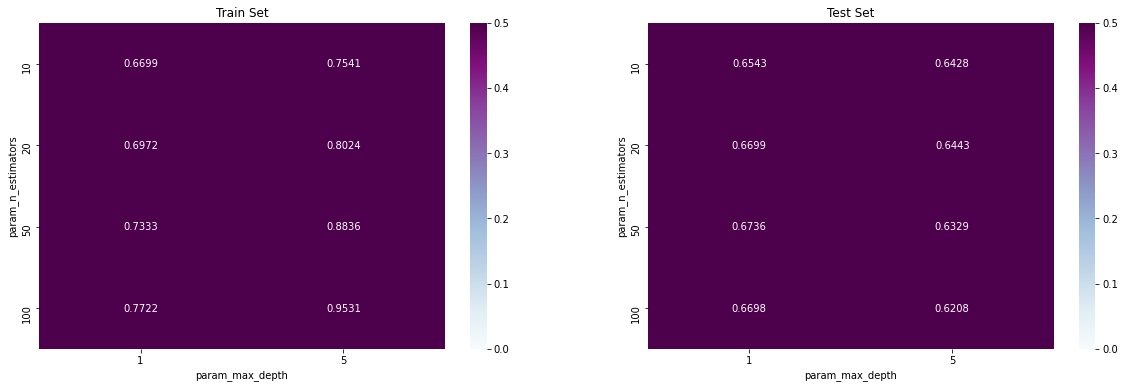

In [70]:
df = pd.DataFrame(model_1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig,ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(df.mean_train_score, annot = True, fmt='.4g', ax=ax[0],cmap="BuPu", vmin=0, vmax=0.5)
sns.heatmap(df.mean_test_score, annot = True, fmt='.4g', ax=ax[1],cmap="BuPu", vmin=0, vmax=0.5)
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()



In [71]:
model_1.best_params_

{'n_estimators': 50, 'max_depth': 1}

def batch_predict(clf, data):
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    return y_data_pred

In [75]:
from  sklearn.metrics  import roc_curve, auc
classifier_for_set1 = GradientBoostingClassifier( n_estimators=50,max_depth = 1)
classifier_for_set1.fit(X_tr,y_train)

GradientBoostingClassifier(max_depth=1, n_estimators=50)

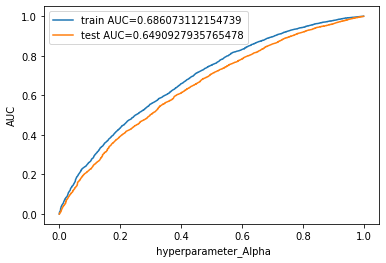

In [76]:
train_predict = batch_predict(classifier_for_set1,X_tr)
test_predict = batch_predict(classifier_for_set1,X_te)
train_fpr,train_tpr,train_thresholds = roc_curve(y_train,train_predict)
test_fpr,test_tpr,test_thresholds = roc_curve(y_test,test_predict)
plt.plot(train_fpr,train_tpr,label="train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="test AUC="+str(auc(test_fpr,test_tpr)))
plt.xlabel(" hyperparameter_Alpha")
plt.ylabel("AUC")
plt.legend()
plt.show()

## confusion matrix on set 1

In [77]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [78]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
print("best threshold",best_t)
print("Train confusion matrix")
confusion_set1_train = confusion_matrix(y_train, predict_with_best_t(train_predict, best_t))
print(confusion_matrix(y_train, predict_with_best_t(train_predict, best_t)))
print("Test confusion matrix")
confusion_set1_test = confusion_matrix(y_test, predict_with_best_t(test_predict, best_t))
print(confusion_matrix(y_test, predict_with_best_t(test_predict, best_t)))

the maximum value of tpr*(1-fpr) 0.3956182289726005 for threshold 0.835
best threshold 0.8354038848376161
Train confusion matrix
[[ 2161  1434]
 [ 6444 12406]]
Test confusion matrix
[[1547 1095]
 [5170 8688]]


<AxesSubplot:>

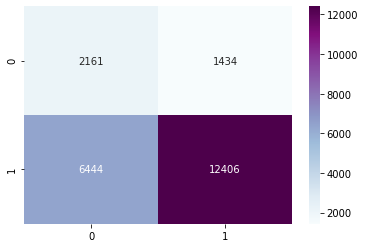

In [79]:
sns.heatmap(confusion_set1_train , annot=True,fmt="d",cmap='BuPu')

<AxesSubplot:>

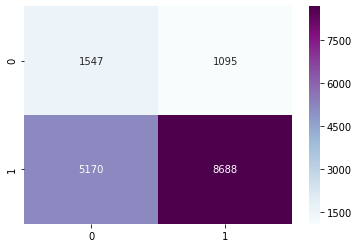

In [80]:
sns.heatmap(confusion_set1_test, annot=True,fmt="d",cmap='BuPu')

## Set 2 Model

In [82]:
decisiontree = GradientBoostingClassifier(random_state=15,learning_rate = 1)
distribution = {"max_depth":[1,5],"n_estimators" : [10,20,50,100]}
model = RandomizedSearchCV(decisiontree,distribution,cv = 3,scoring="roc_auc",return_train_score = True,verbose = 10)
model_2 = model.fit(X_tr_2,y_train)

C:\Users\dipali\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START max_depth=1, n_estimators=10................................
[CV 1/3; 1/8] END max_depth=1, n_estimators=10;, score=(train=0.665, test=0.656) total time=   3.2s
[CV 2/3; 1/8] START max_depth=1, n_estimators=10................................
[CV 2/3; 1/8] END max_depth=1, n_estimators=10;, score=(train=0.667, test=0.657) total time=   3.1s
[CV 3/3; 1/8] START max_depth=1, n_estimators=10................................
[CV 3/3; 1/8] END max_depth=1, n_estimators=10;, score=(train=0.677, test=0.650) total time=   3.0s
[CV 1/3; 2/8] START max_depth=1, n_estimators=20................................
[CV 1/3; 2/8] END max_depth=1, n_estimators=20;, score=(train=0.694, test=0.674) total time=   6.7s
[CV 2/3; 2/8] START max_depth=1, n_estimators=20................................
[CV 2/3; 2/8] END max_depth=1, n_estimators=20;, score=(train=0.694, test=0.668) total time=   6.5s
[CV 3/3; 2/8] START max_depth=1, n_

In [83]:

joblib.dump(model_2, 'gbdtset2.pkl')

['gbdtset2.pkl']

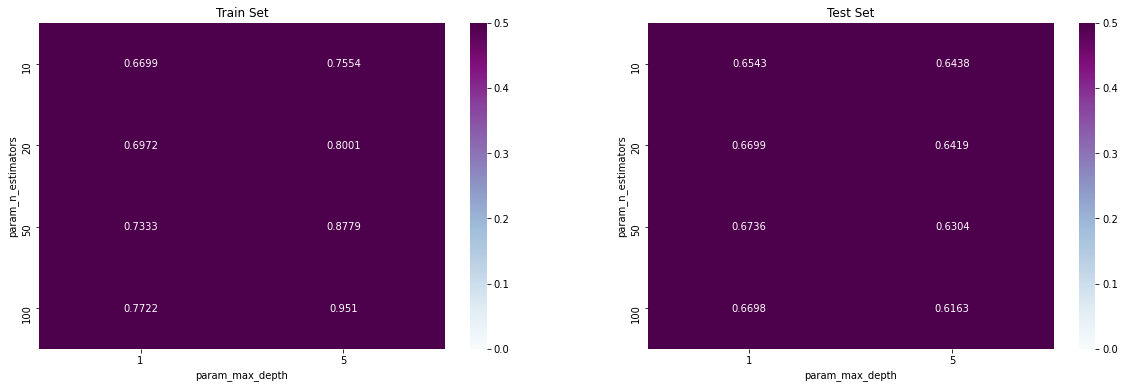

In [84]:
df = pd.DataFrame(model_2.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig,ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(df.mean_train_score, annot = True, fmt='.4g', ax=ax[0],cmap="BuPu", vmin=0, vmax=0.5)
sns.heatmap(df.mean_test_score, annot = True, fmt='.4g', ax=ax[1],cmap="BuPu", vmin=0, vmax=0.5)
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()



In [85]:
model_2.best_params_

{'n_estimators': 50, 'max_depth': 1}

In [86]:
from  sklearn.metrics  import roc_curve, auc
classifier_for_set2 = GradientBoostingClassifier( n_estimators=50,max_depth = 1)
classifier_for_set2.fit(X_tr_2,y_train)

GradientBoostingClassifier(max_depth=1, n_estimators=50)

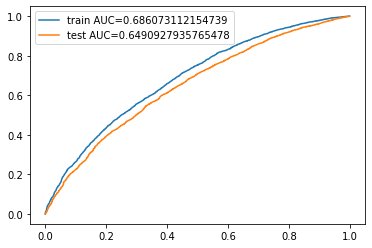

In [88]:
train_predict_2 = batch_predict(classifier_for_set2,X_tr_2)
test_predict_2 = batch_predict(classifier_for_set2,X_te_2)
train_fpr_2,train_tpr_2,train_thresholds_2 = roc_curve(y_train,train_predict_2)
test_fpr_2,test_tpr_2,test_thresholds_2 = roc_curve(y_test,test_predict_2)
plt.plot(train_fpr_2,train_tpr_2,label="train AUC="+str(auc(train_fpr_2,train_tpr_2)))
plt.plot(test_fpr_2,test_tpr_2,label="test AUC="+str(auc(test_fpr_2,test_tpr_2)))
plt.legend()
plt.show()

In [89]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t_2 = find_best_threshold(train_thresholds_2, train_fpr_2, train_tpr_2)
print("best threshold",best_t_2)
print("Train confusion matrix")
confusion_set2_train = confusion_matrix(y_train, predict_with_best_t(train_predict_2, best_t_2))
print(confusion_matrix(y_train, predict_with_best_t(train_predict, best_t)))
print("Test confusion matrix")
confusion_set2_test = confusion_matrix(y_test, predict_with_best_t(test_predict_2, best_t_2))
print(confusion_matrix(y_test, predict_with_best_t(test_predict, best_t)))

the maximum value of tpr*(1-fpr) 0.3956182289726005 for threshold 0.835
best threshold 0.8354038848376161
Train confusion matrix
[[ 2161  1434]
 [ 6444 12406]]
Test confusion matrix
[[1547 1095]
 [5170 8688]]


<AxesSubplot:>

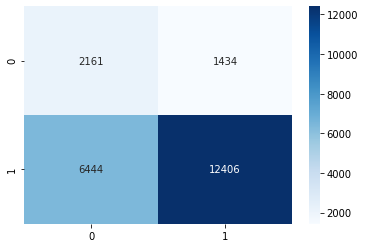

In [90]:
sns.heatmap(confusion_set2_train, annot=True,fmt="d",cmap='Blues')

<AxesSubplot:>

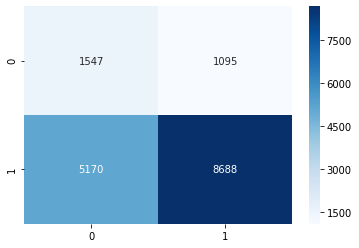

In [91]:
sns.heatmap(confusion_set2_test, annot=True,fmt="d",cmap='Blues')

<h1> Summary</h1>

In [95]:
table = PrettyTable()
table.field_names = ("vectorize","max_Deptyh","n_estimators","test_Auc")
table.add_row(["TFIDF","1","50","0.64"])
table.add_row(["TFIDFW2V","1","50","0.64"])
print(table)

+-----------+------------+--------------+----------+
| vectorize | max_Deptyh | n_estimators | test_Auc |
+-----------+------------+--------------+----------+
|   TFIDF   |     1      |      50      |   0.64   |
|  TFIDFW2V |     1      |      50      |   0.64   |
+-----------+------------+--------------+----------+


### Reference

In [ ]:
# https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
# https://stackoverflow.com/questions/55663030/plotting-two-heat-maps-side-by-side-in-matplotlib
#https://blog.csdn.net/w55100/article/details/90369779
